In [17]:
import pandas as pd
import numpy as np
import pingouin as pg
from calc_pxp import bms 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk',font_scale=2)
sns.set_style('white')

save_plots=False

In [2]:
subs=[  0,   1,   3,   4,   5,   7,   8,   9,  10,  12,  13,  16,  17,
        18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,  30,  32,
        33,  34,  35,  37,  40,  41,  42,  43,  44,  46,  47,  49,  50,
        51,  53,  57,  58,  60,  62,  63,  64,  65,  67,  68,  70,  73,
        74,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  89,
        90,  91,  92,  93,  94,  97,  98,  99, 100, 101, 103, 104, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134,
       135, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 157, 160, 161, 162, 163, 165, 166,
       167, 168, 169, 172, 173, 177, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 189, 190, 191, 193, 194, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215,
       216, 217, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 237, 239, 240, 241, 242, 243, 245, 247,
       249, 251, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 281, 282, 283, 284, 286, 287, 289, 290, 291, 292,
       293, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       308, 310, 311, 312, 313]

ages_df = pd.read_csv("data/sub_ages_20240417.csv")

alpha_dict = {0:0,1:0.2}



In [3]:
df = pd.DataFrame()
import scipy.stats as stats
alpha_dict = {0:0,1:0.2}

max_alpha=2
for sub in subs:
    age=ages_df.query("sub_num==@sub").age.values[0]
    age_group=ages_df.query("sub_num==@sub").age_group.values[0]
    for alpha in range(max_alpha):

        try:
            curr_df = pd.read_csv("softmax/neg_llh_alpha_"+str(int(alpha))+"/sub"+str(sub)+".csv")
            neg_llh = curr_df.neg_llh
            gamma_base = curr_df.gamma_base
            gamma_coef = curr_df.gamma_coef
            beta = curr_df.beta
            epsilon = curr_df.epsilon
            
            if alpha == 0:
                n_params = 3
            elif alpha == 1:
                n_params = 4

            temp = pd.DataFrame({'sub_num':[sub],'age':[age],'age_group':[age_group],'model':str(alpha_dict[alpha]),'neg_llh':neg_llh,'gamma_base':gamma_base,'gamma_coef':gamma_coef,'beta':beta,'epsilon':epsilon,'n_params':n_params},index=[0])
            df = pd.concat([df,temp])
                
        except:
            print("ALPHA:" + str(alpha))
            print("SUB:" + str(sub))

            continue
        
df['log_likelihood'] = -df['neg_llh']
df['AIC'] = 2*df['neg_llh'] + 2*df['n_params']
df['sign_invert_AIC'] = -2*df['AIC'] #https://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/#a-note-on-model-scores-vb-free-eneergy-aic-or-bic, multiply by -2 to invert the sign

df['posterior_prob'] = np.exp(df['log_likelihood'])

child_df = df.query("age_group=='child'").reset_index()
adol_df = df.query("age_group=='adolescent'").reset_index()
adult_df = df.query("age_group=='adult'").reset_index()

# Get model with lowest cv_score for each subject
best_models_child = child_df.loc[child_df.groupby('sub_num')['AIC'].idxmin()].reset_index()    
best_models_adol = adol_df.loc[adol_df.groupby('sub_num')['AIC'].idxmin()].reset_index()
best_models_adult = adult_df.loc[adult_df.groupby('sub_num')['AIC'].idxmin()].reset_index()

df = pd.concat([child_df,adol_df,adult_df])


In [6]:
# Calculate difference in neg_llh between model 0 and 0.2 for each subject
df_wide = df.pivot(index='sub_num', columns='model', values='AIC').reset_index()
df_wide['aic_diff'] = df_wide['0'] - df_wide['0.2']
df_wide = df_wide.merge(df[['sub_num', 'age', 'age_group']].drop_duplicates(), on='sub_num')

## Model comparison metrics vs age

            n         r        CI95%     p-val     power
spearman  252  0.221281  [0.1, 0.34]  0.000401  0.944859


Text(34.97500000000001, 0.5, 'AIC(α=0) - AIC(α*)')

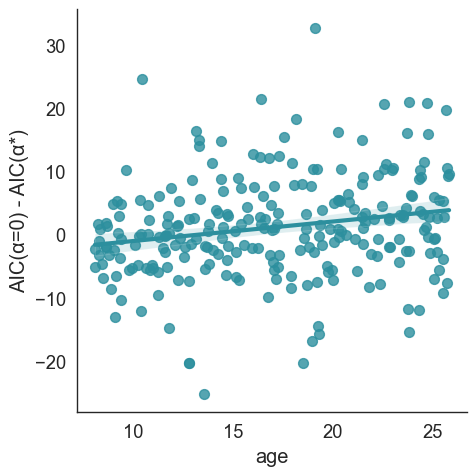

In [ ]:
sns.set_context('paper',font_scale=1.5)

print(pg.corr(df_wide['age'],df_wide['aic_diff'],method='spearman'))
sns.lmplot(x="age", y="aic_diff", data=df_wide,scatter_kws={'color': '#2c8f9e','s':50}, line_kws={'color': '#2c8f9e','linewidth':3})
plt.ylabel("AIC(α=0) - AIC(α*)")
if save_plots:
    plt.savefig('age_aic_diff_alpha_bin_0_02_softmax.png', bbox_inches="tight", dpi=300, transparent=True)


## Fitted model parameters vs age

            n         r          CI95%     p-val     power
spearman  252 -0.091736  [-0.21, 0.03]  0.146477  0.306757


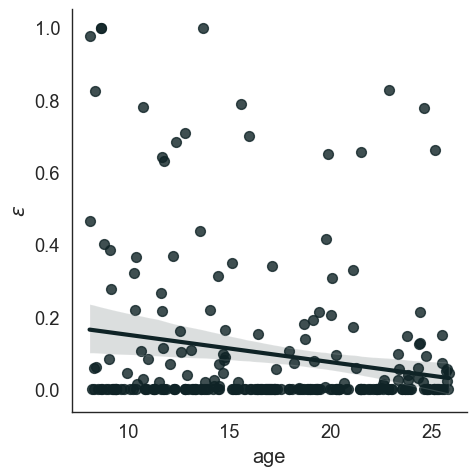

In [18]:
sns.set_context('paper',font_scale=1.5)
model_num='0.2'
model_df=df.query("model==@model_num")
model_df= model_df[['sub_num','age','age_group','gamma_base','gamma_coef','beta','epsilon']]
#temp=params_only.groupby(by=['sub_num']).mean().reset_index()

curr_param = 'epsilon'

print(pg.corr(model_df['age'],model_df[curr_param],method='spearman'))

sns.lmplot(x="age", y=curr_param, data=model_df, scatter_kws={'color': '#0f2326','s':50}, line_kws={'color': '#0f2326','linewidth':3})

if curr_param == 'gamma_base':
    label = r"$\gamma_{base}$"
elif curr_param == 'gamma_coef':
    label = r"$\gamma_{coef}$"
elif curr_param == 'beta':
    label = r"$\beta$"
elif curr_param == 'epsilon':
    label = r"$\epsilon$"
plt.ylabel(label)

if save_plots:
    plt.savefig(curr_param+'_age_alpha_'+model_num+'.png', bbox_inches="tight", dpi=300, transparent=True)


## Protected exceedence probabilities by age group

In [18]:
def return_pxp(age_group_df):
    age_group_df=age_group_df[['sub_num','model','sign_invert_AIC']].groupby(by=["sub_num","model"]).mean().reset_index()
    llh = age_group_df.pivot(index='sub_num', columns='model', values='sign_invert_AIC').to_numpy()
    alpha,exp_r,xp,pxp,bor,g=bms(llh)

    return  alpha,exp_r,xp,pxp,bor,g

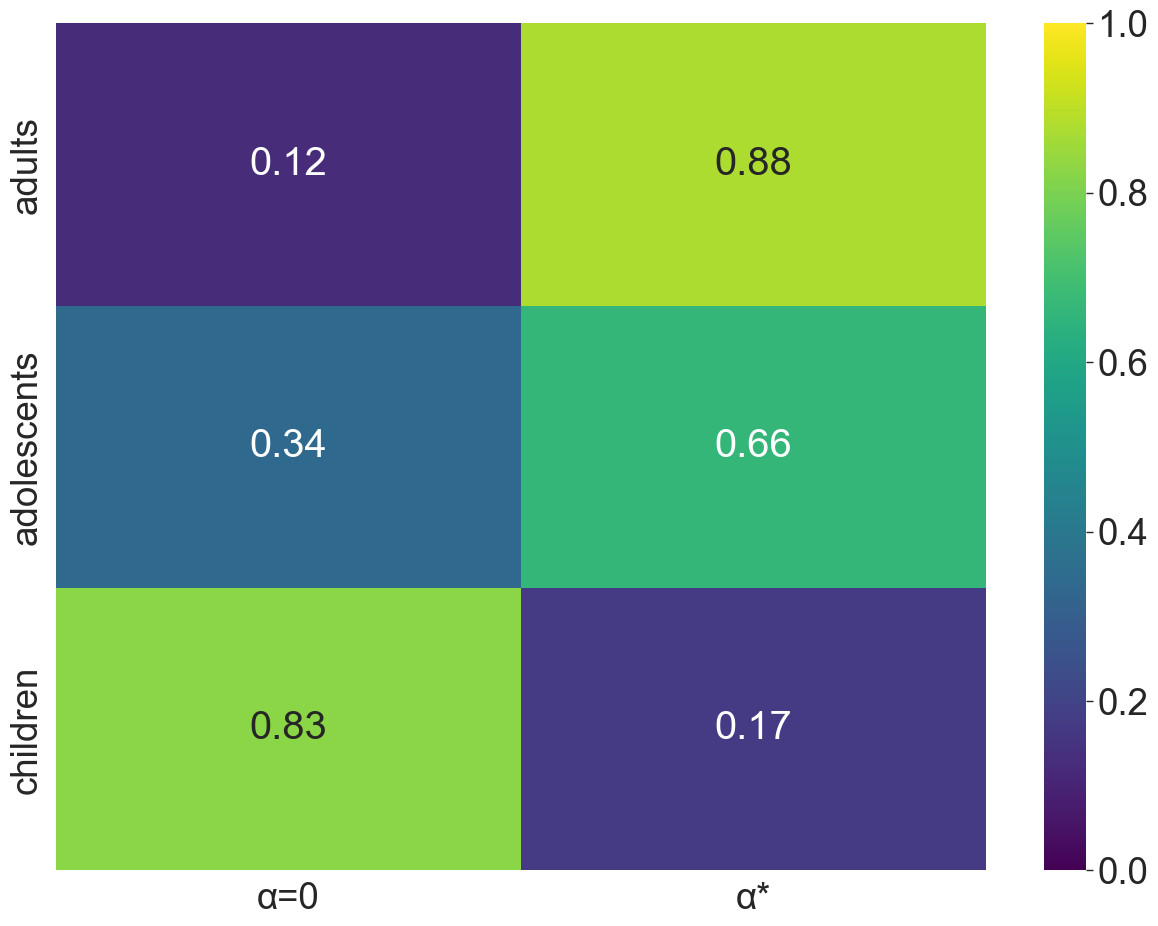

In [20]:
plt.rcParams["figure.figsize"] = (15,11)
sns.set_context('paper',font_scale=3)

child_alpha,child_exp_r,child_xp,child_pxp,child_bor,child_g = return_pxp(child_df)
adol_alpha,adol_exp_r,adol_xp,adol_pxp,adol_bor,adol_g = return_pxp(adol_df)
adult_alpha,adult_exp_r,adult_xp,adult_pxp,adult_bor,adult_g = return_pxp(adult_df)


data = np.squeeze(np.array([adult_pxp,adol_pxp,child_pxp]))

ax = sns.heatmap(data, annot=True, cmap="viridis", vmin=0, vmax=1, fmt='.2f')

labels = ['0','*']
ax.set_yticklabels(['adults','adolescents','children'])
ax.set_xlabel("")
ax.set_xticklabels(['α=0','α*'])
if save_plots:
plt.savefig('pxp_alpha_bin_0_02_softmax.png',bbox_inches = "tight",dpi=300,transparent=True)